In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa as tsa
import statistics
import tqdm
import heapq as queue
import math

input_file = open('prices.txt', 'r')
number_of_stocks = 50
price_list = []

for i in range(number_of_stocks):
    price_list.append([])

for line in input_file:
    tokens = line.split('\n')[0].split('   ')
    #print(tokens)
    #break
    for i in range(number_of_stocks):
        price_list[i].append(float(tokens[i]))
df = pd.DataFrame()

for i in range(number_of_stocks):
    df[f'stock_{i}'] = price_list[i]

train_n = 250

df_train = df.iloc[:train_n]
df_test = df.iloc[train_n:]

C:\Users\Yihan\AppData\Local\Temp\ipykernel_13464\3327931266.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


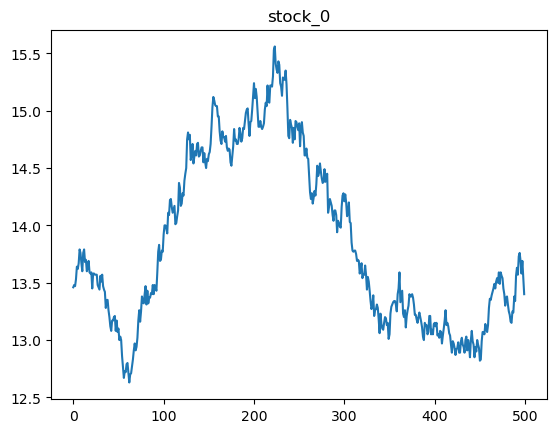

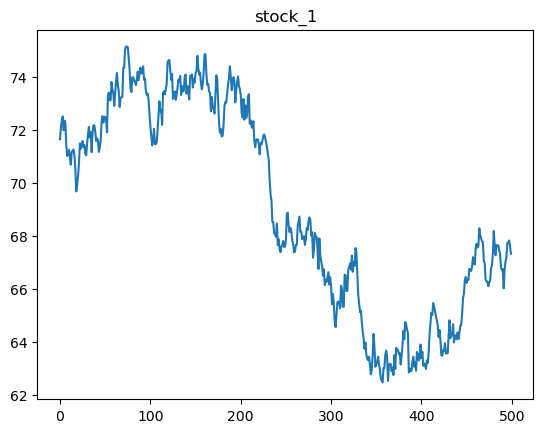

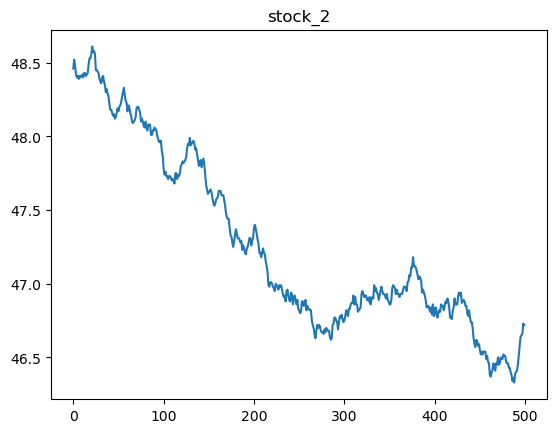

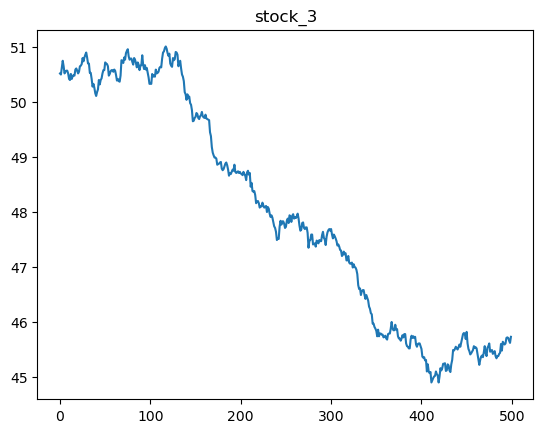

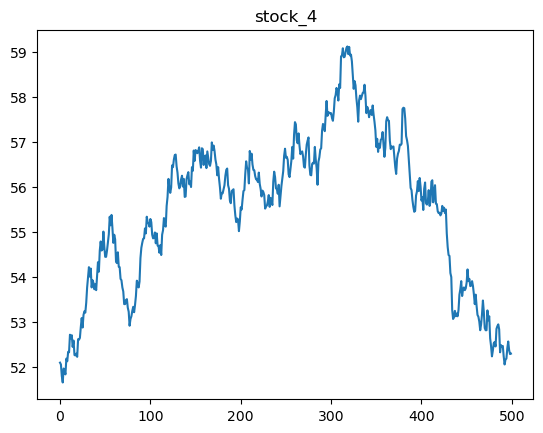

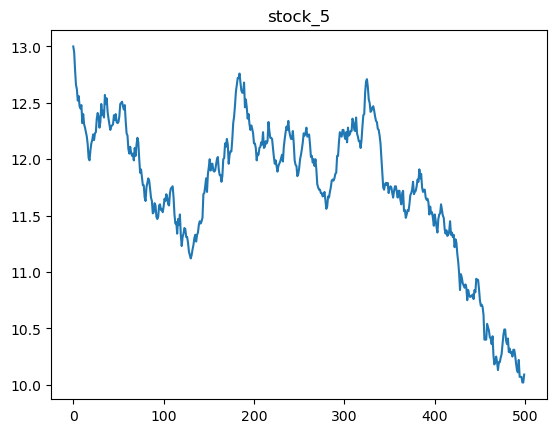

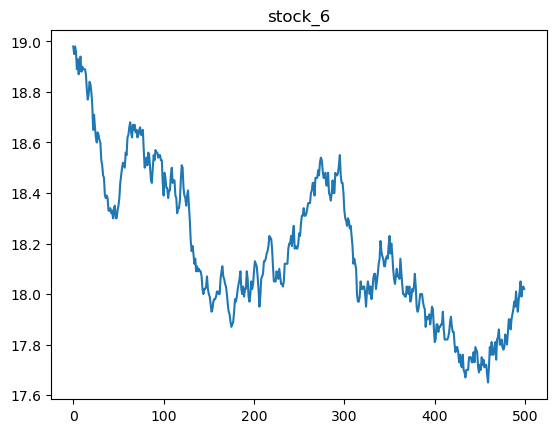

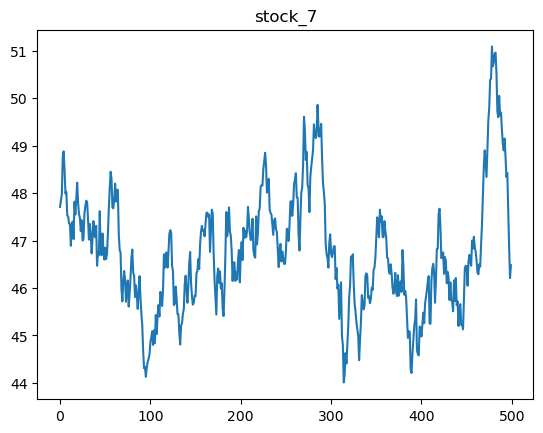

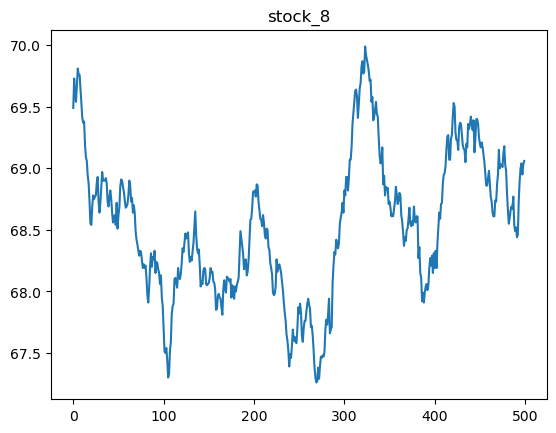

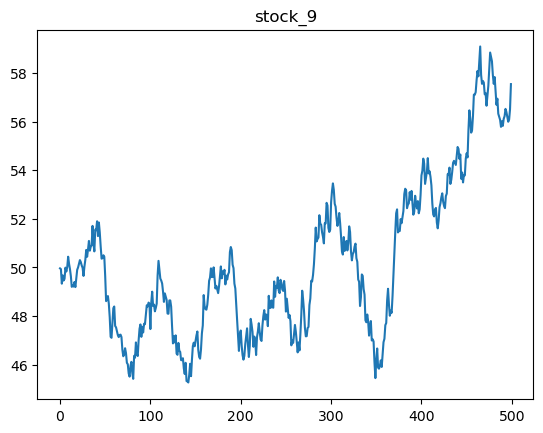

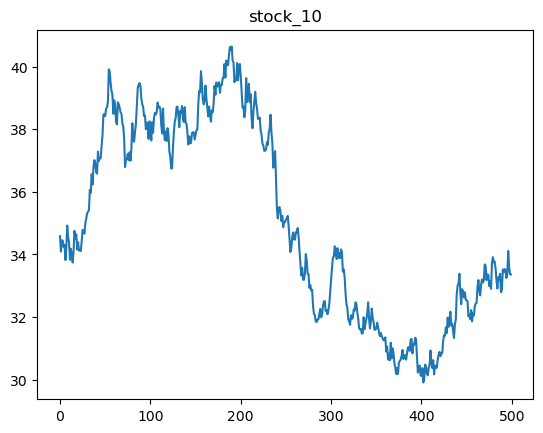

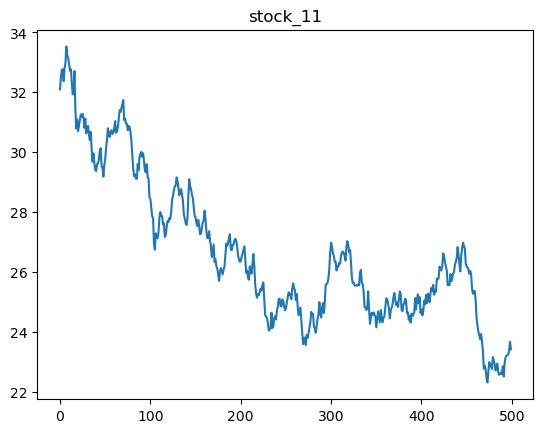

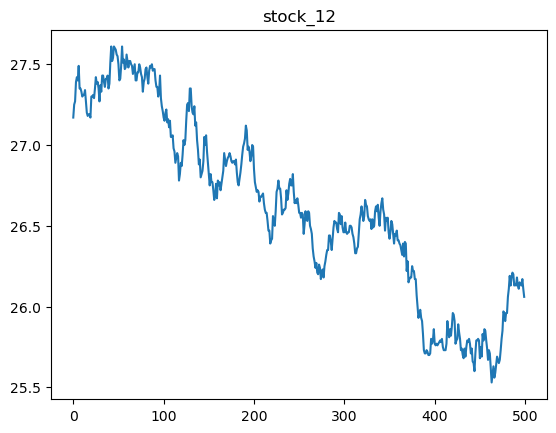

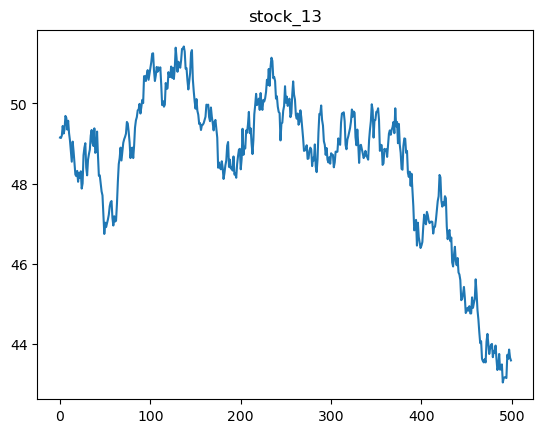

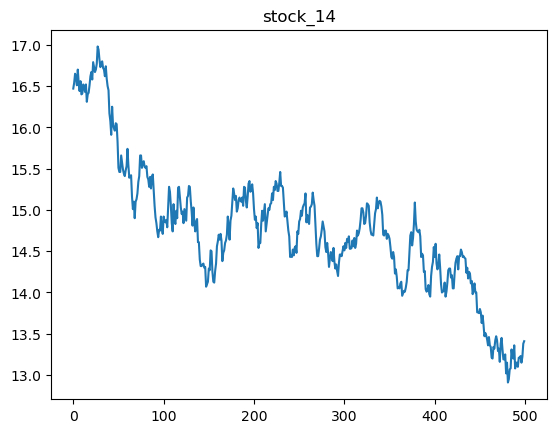

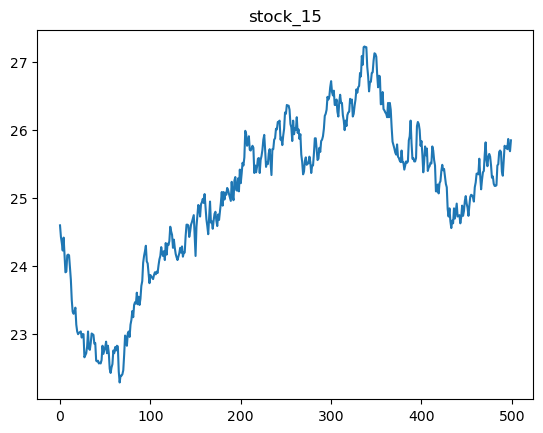

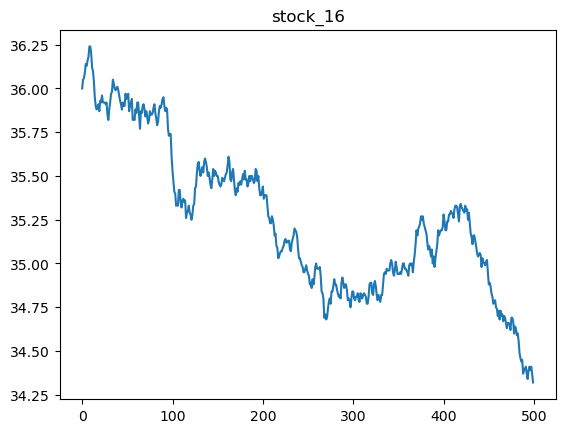

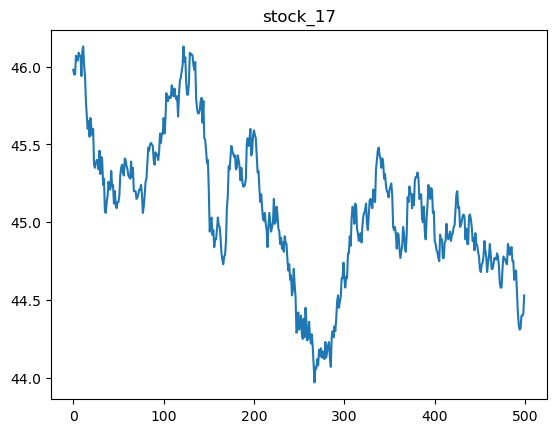

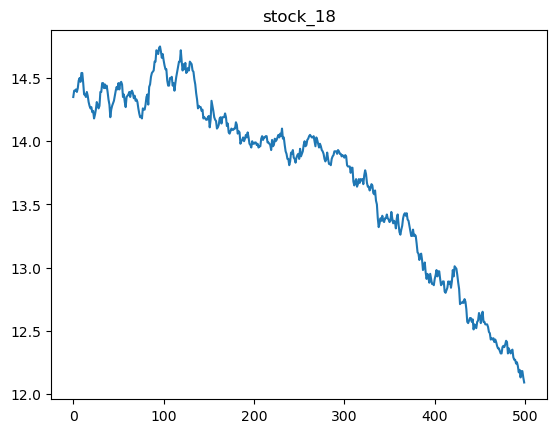

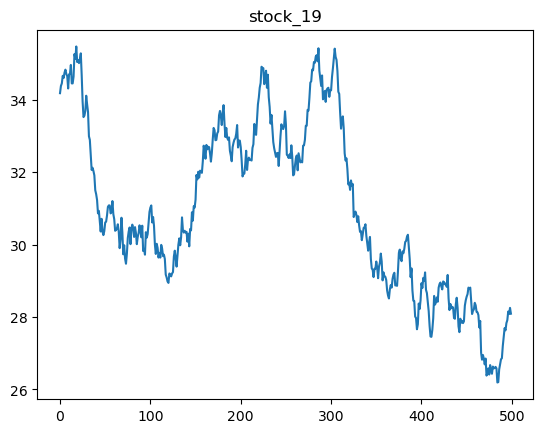

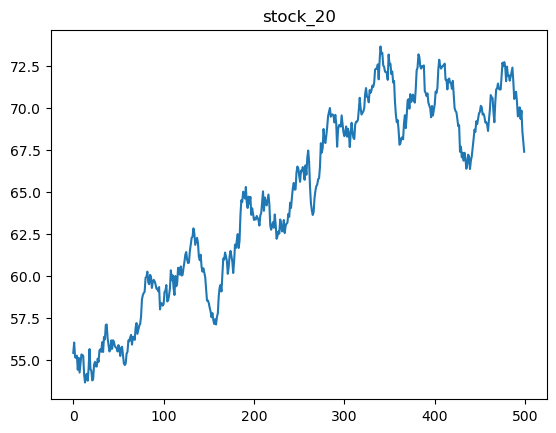

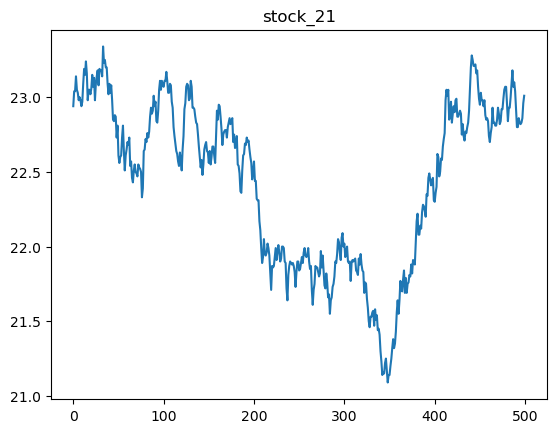

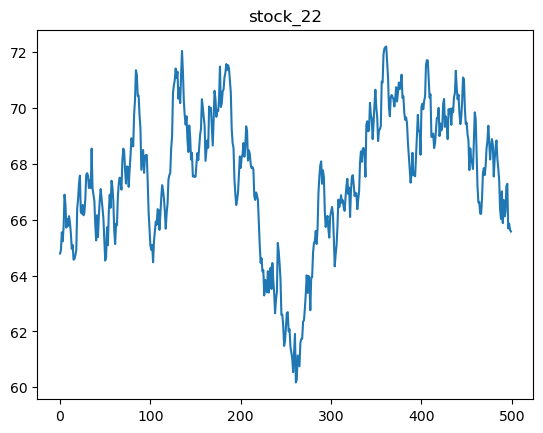

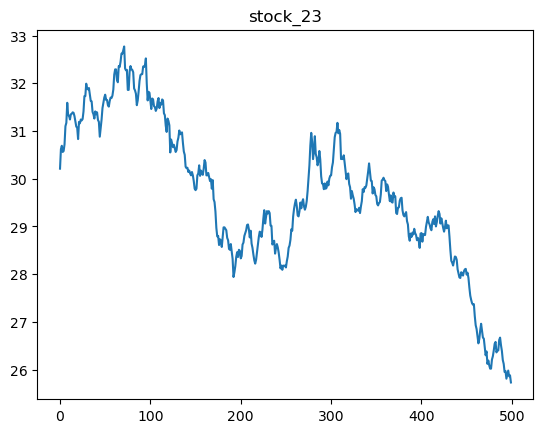

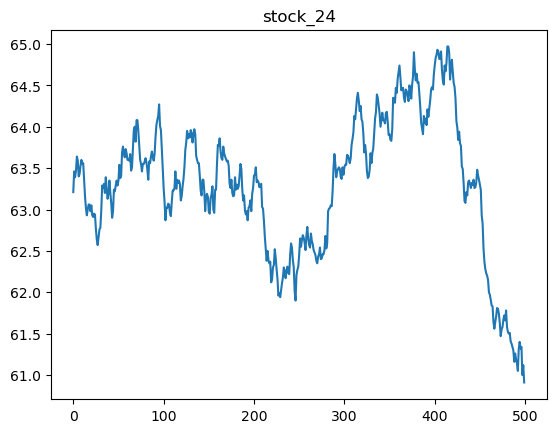

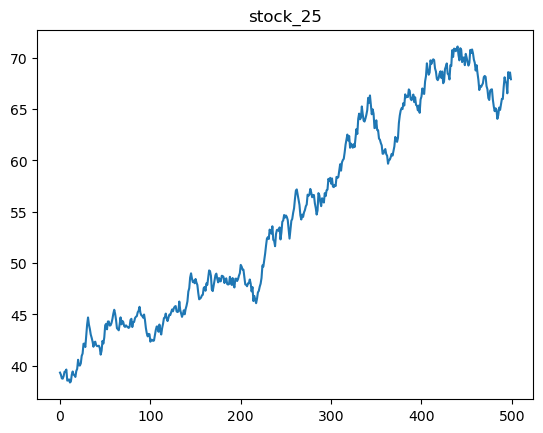

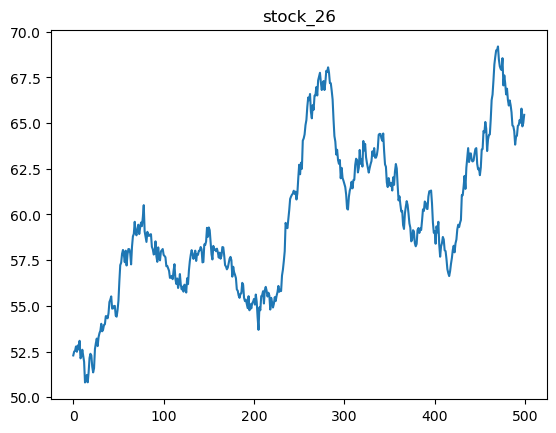

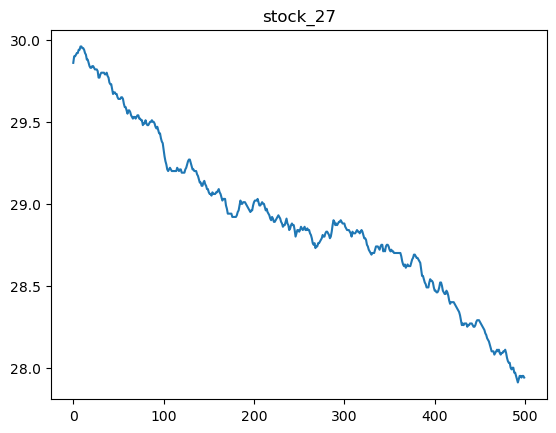

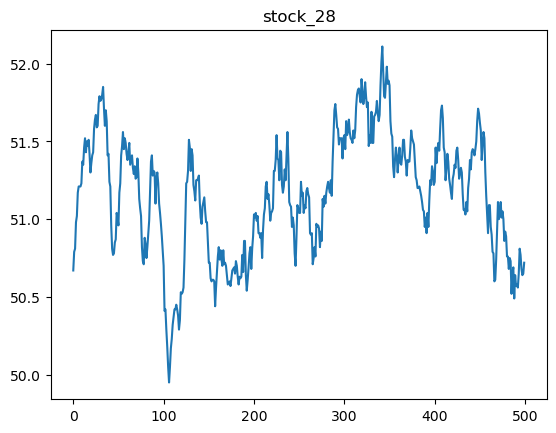

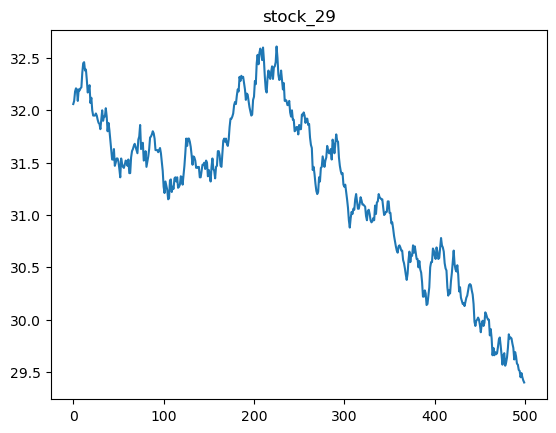

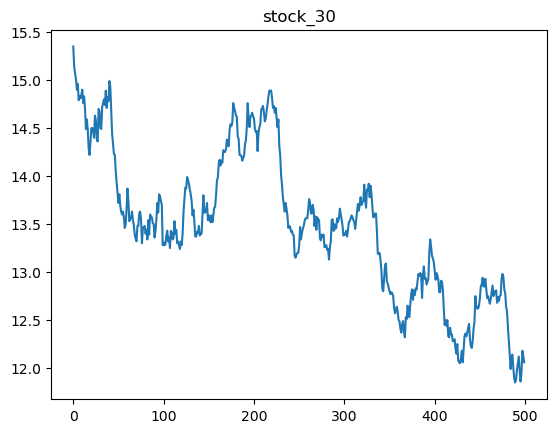

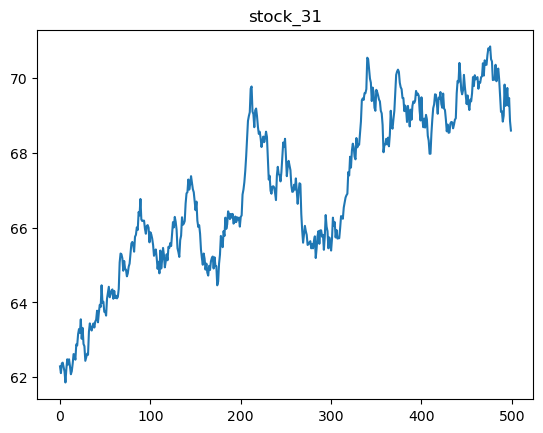

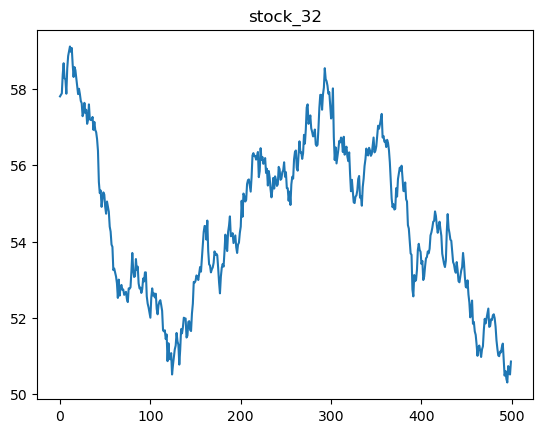

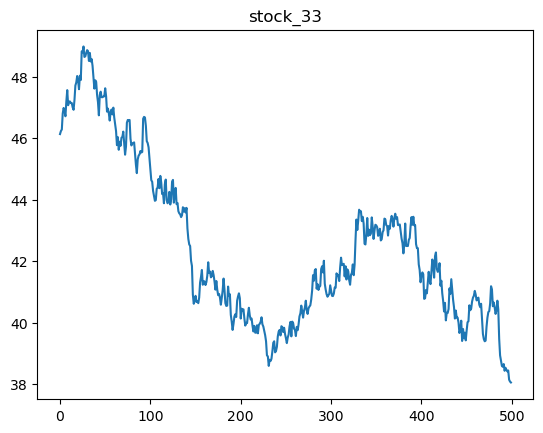

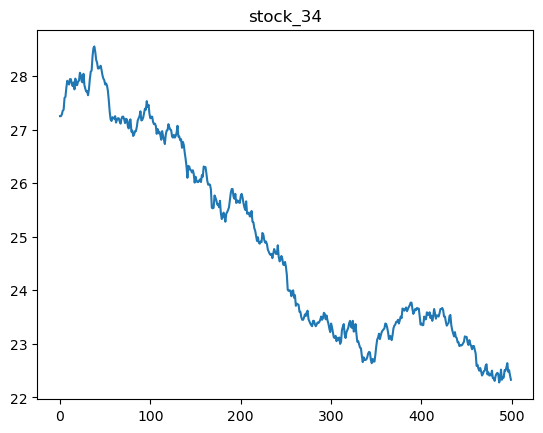

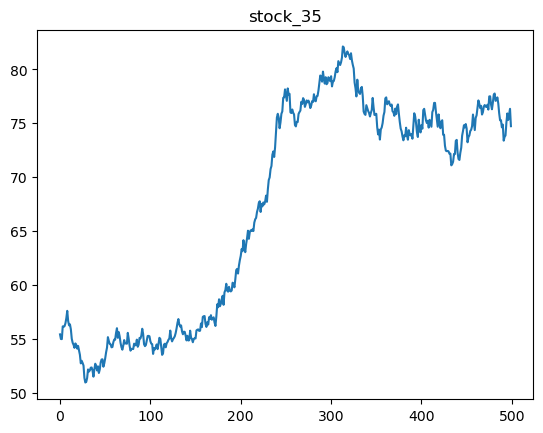

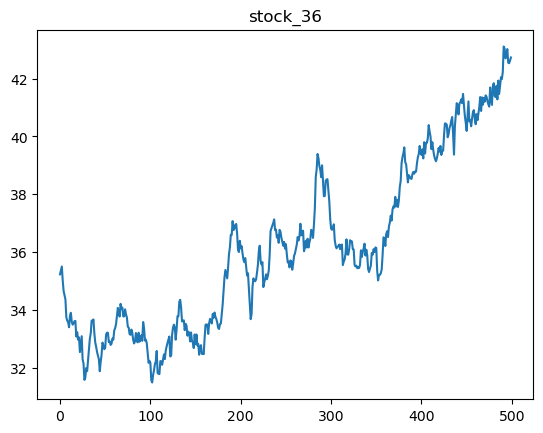

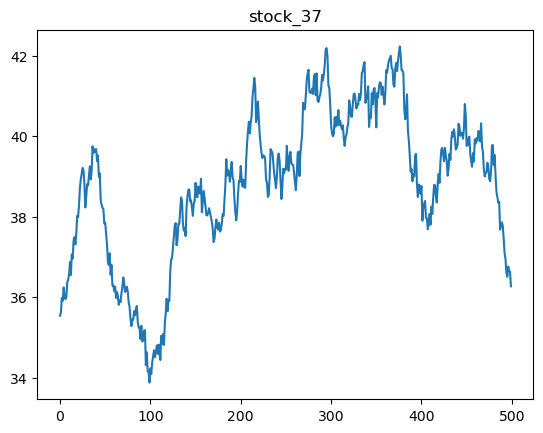

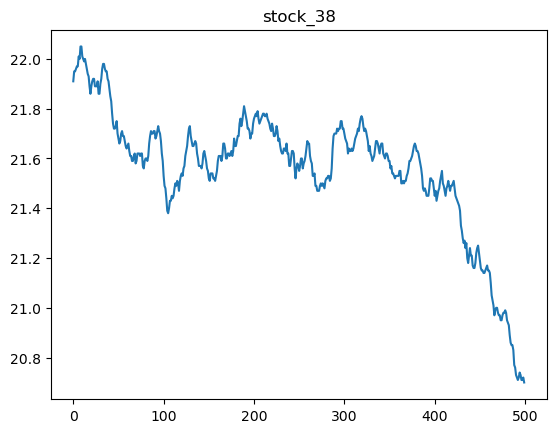

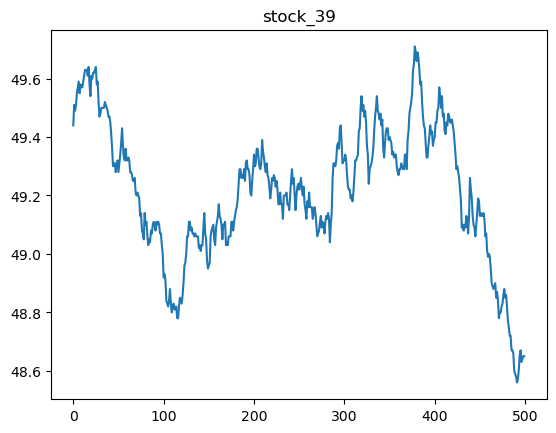

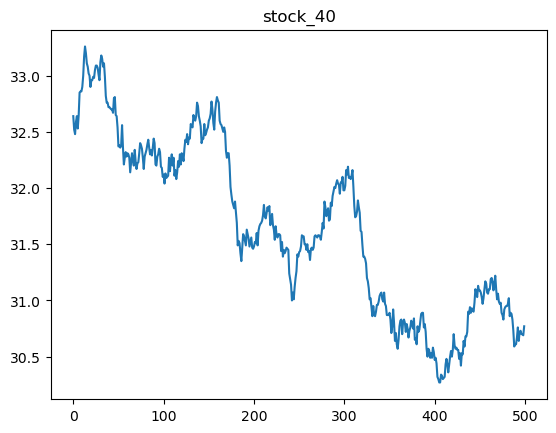

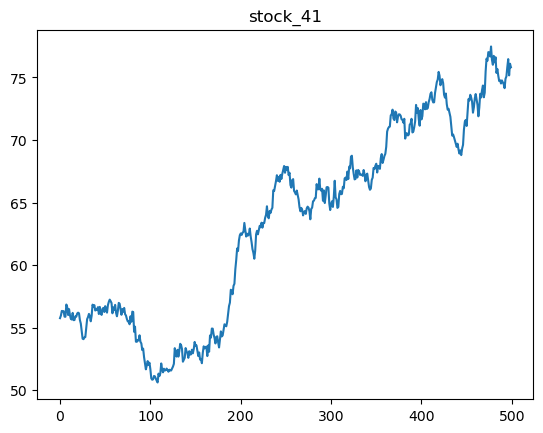

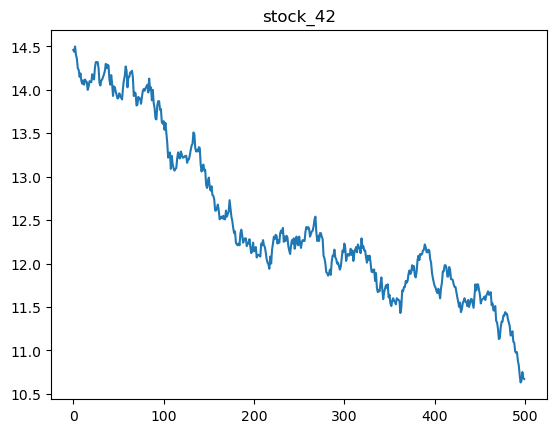

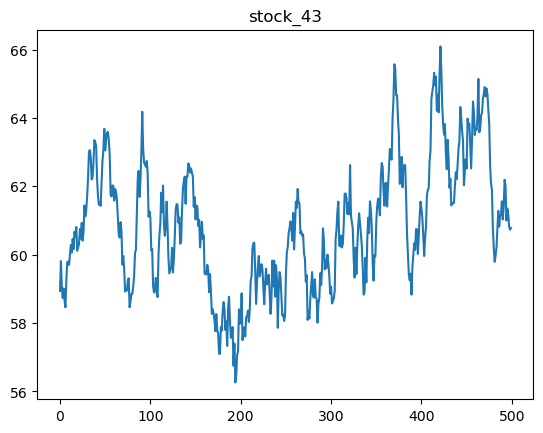

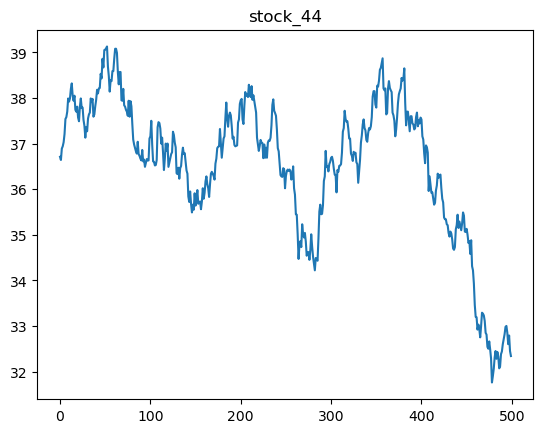

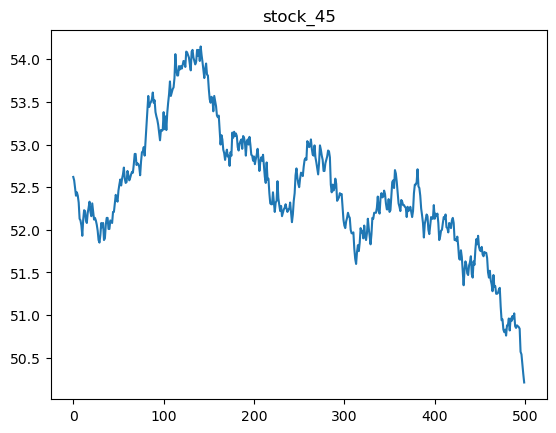

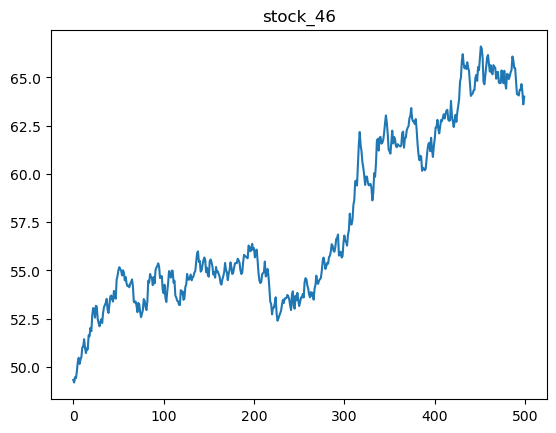

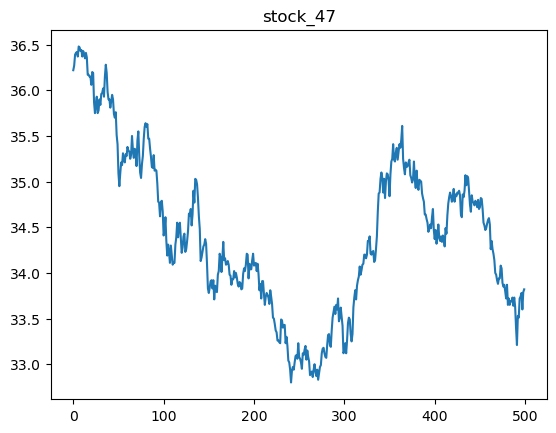

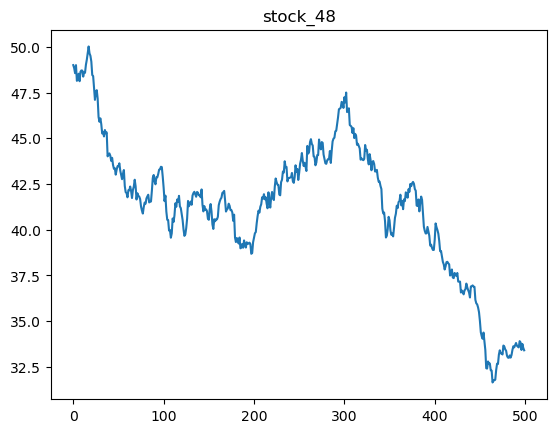

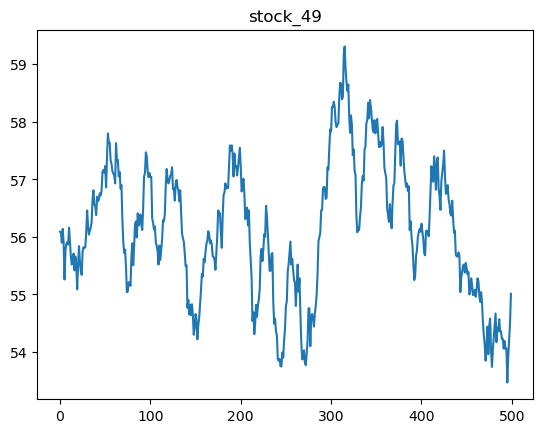

<Figure size 640x480 with 0 Axes>

In [3]:
for i in range(number_of_stocks):
    plt.plot(df[f'stock_{i}'])
    plt.title(f'stock_{i}')
    plt.figure()

## Stock 0

In [4]:
target_stock = 1

feature_window = 10
alpha = 0.05

models = []
for j in range(number_of_stocks):
    if j == target_stock:
        continue
    df_temp = pd.DataFrame()
    df_temp[f'stock_{target_stock}_window_{feature_window}'] = df_test[f'stock_{target_stock}'].diff(feature_window)
    df_temp[f'stock_{j}_window_{feature_window}_offset_{1}'] = df_test[f'stock_{j}'].diff(feature_window).shift(feature_window)
    df_temp[f'stock_{target_stock}_window_{feature_window}_offset_{1}'] = df_test[f'stock_{target_stock}'].diff(feature_window).shift(feature_window)

    df_temp.dropna(inplace = True)
    y = df_temp[f'stock_{target_stock}_window_{feature_window}']
    X = sm.add_constant(df_temp[[f'stock_{j}_window_{feature_window}_offset_{1}', f'stock_{target_stock}_window_{feature_window}_offset_{1}']])

    model = sm.OLS(y, X)
    results = model.fit(vcov = 'HC3')
    if results.pvalues[f'stock_{j}_window_{feature_window}_offset_{1}'] < alpha and results.pvalues[f'stock_{target_stock}_window_{feature_window}_offset_{1}'] < alpha:
        print(f'stock_{j}_window_{feature_window}_offset_{1}')
        print(results.summary())
        #models.append((f'stock_{j}_window_{feature_window}_offset_{1}', results.params[f'stock_{j}_window_{feature_window}_offset_{1}'], results.params['const']))

stock_2_window_10_offset_1
                            OLS Regression Results                            
Dep. Variable:      stock_1_window_10   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     7.994
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           0.000442
Time:                        17:53:59   Log-Likelihood:                -356.97
No. Observations:                 230   AIC:                             719.9
Df Residuals:                     227   BIC:                             730.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [87]:
correct = 0
incorrect = 0

forecasts_list = []
targets_list = []

for t in range(350, 400):
    aggregated_signal = 0
    for feature, m, c in models:
        arr = feature.split('_')
        iv_stock = int(arr[1])
        window = int(arr[3])
        lookback_no = int(arr[5])

        feature = df.iloc[t][f'stock_{iv_stock}'] - df.iloc[t - window][f'stock_{iv_stock}']
        forecast = m * feature + c
        if t < len(df) - window:
            target = df.iloc[t + window][f'stock_{target_stock}'] - df.iloc[t][f'stock_{target_stock}']
            forecasts_list.append(forecast)
            targets_list.append(target)
            if target * forecast > 0:
                correct += 1
            else:
                incorrect += 1
            

In [88]:
correct

244

In [89]:
incorrect

356

## Most Volatile Stocks

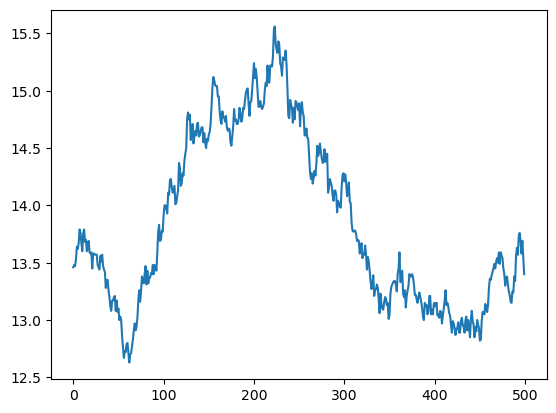

In [117]:
plt.plot(df['stock_0'])

In [135]:
for i in range(50):
    unique_diffs = len(df[f'stock_{i}'].diff().unique())
    if unique_diffs < 50:
        print(f'stock {i} has {unique_diffs} unique price jumps')

stock 2 has 35 unique price jumps
stock 6 has 35 unique price jumps
stock 16 has 40 unique price jumps
stock 18 has 42 unique price jumps
stock 27 has 18 unique price jumps
stock 38 has 25 unique price jumps
stock 39 has 39 unique price jumps


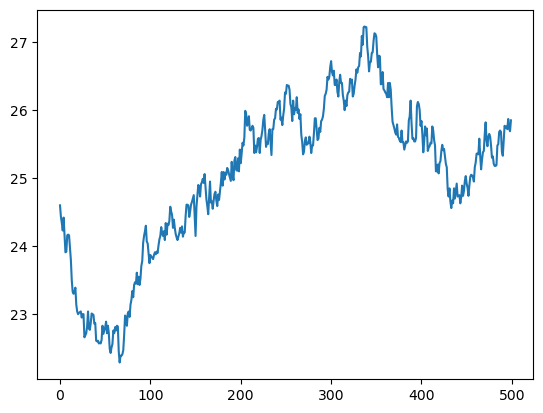

In [43]:
#plt.scatter(df[f'stock_2'].diff(), df[f'stock_6'].diff())
plt.plot(df[f'stock_15'])

In [12]:
tsa.stattools.coint(df['stock_39'], df['stock_38'])

(-2.060180763056524,
 0.4971881716193898,
 array([-3.91852234, -3.34840209, -3.05296032]))

In [17]:
rsquared_limit = 0.99
alpha = 0.01
for i in range(number_of_stocks):
    print(f'{i}', end = ' ')
    for j in range(number_of_stocks):
        if i != j:
            for k in range(number_of_stocks):
                if k != j and k != i:
                    X = sm.add_constant(df_train[[f'stock_{i}', f'stock_{j}']])
                    y = df_train[f'stock_{k}']
                    model = sm.OLS(y, X)
                    results = model.fit(vcov = 'HC3')
                    if results.pvalues[f'stock_{i}'] < alpha and results.pvalues[f'stock_{j}'] < alpha and \
                    results.rsquared > rsquared_limit:
                        print(results.summary())

                    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [8]:
set(round(df['stock_27'].diff(), 2))

{-0.04, -0.03, -0.02, -0.01, 0.0, 0.03, nan, 0.01, 0.02, 0.04}

In [23]:
df_new = df.copy()

for i in range(number_of_stocks):
    df_new[f'diff_{i}'] = df_new[f'stock_{i}'].diff()
df_new.dropna(inplace = True)
for i in range(number_of_stocks):
    df_new[f'sign_{i}'] = np.sign(df_new[f'diff_{i}'])

C:\Users\Yihan\AppData\Local\Temp\ipykernel_13464\3925587916.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'sign_{i}'] = np.sign(df_new[f'diff_{i}'])


In [27]:
df_new['overall_direction'] = np.zeros(len(df_new))

for i in range(number_of_stocks):
    df_new['overall_direction'] = df_new['overall_direction'] + df_new[f'sign_{i}']

C:\Users\Yihan\AppData\Local\Temp\ipykernel_13464\334423303.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new['overall_direction'] = np.zeros(len(df_new))


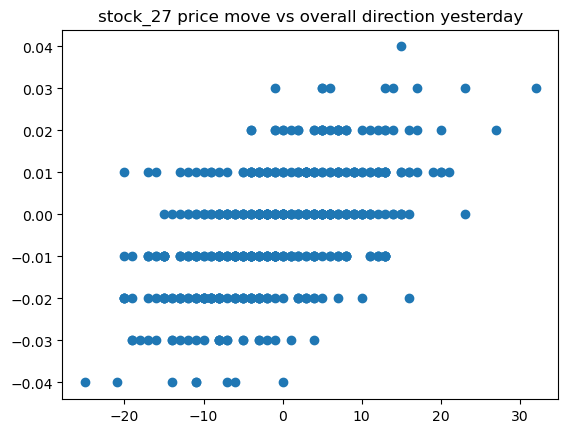

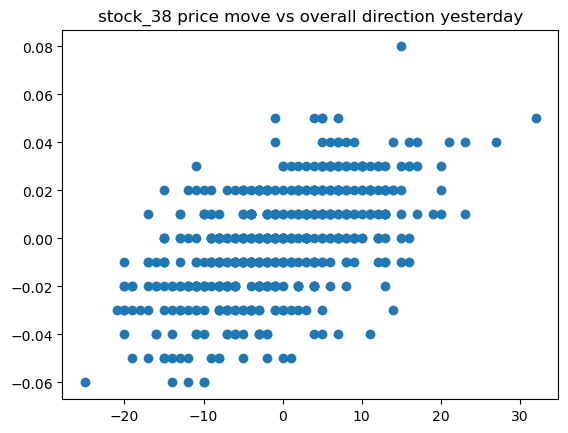

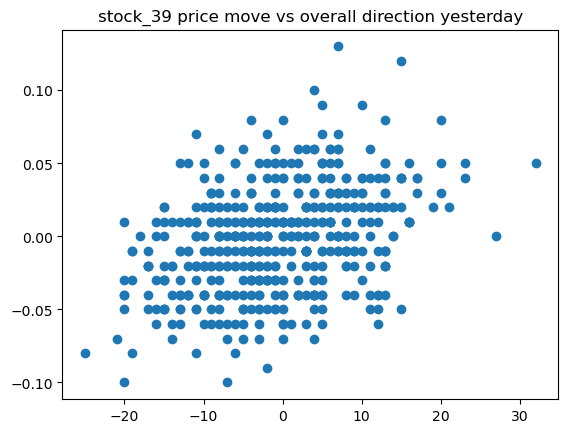

<Figure size 640x480 with 0 Axes>

In [58]:
df_new_train = df_new
for i in [27, 38, 39]:
    df_temp = pd.DataFrame()
    df_temp[f'diff_{i}'] = df_new_train[f'diff_{i}']
    df_temp[f'yesterday_direction'] = df_new_train[f'overall_direction'].shift(1)

    df_temp.dropna(inplace = True)
    corrcoef = np.corrcoef(df_temp['yesterday_direction'], df_temp[f'diff_{i}'])[0, 1]
    #if abs(corrcoef) > 0.35:
    plt.title(f'stock_{i} price move vs overall direction yesterday')
    plt.scatter(df_temp['yesterday_direction'], df_temp[f'diff_{i}'])
    plt.figure()
    
    y = df_temp[f'diff_{i}']
    X = sm.add_constant(df_temp['yesterday_direction'])
    model = sm.OLS(y, X)
    results = model.fit(vcov = 'HC3')
    #print(results.summary())
    
    

In [ ]:
df_new_train = df_new[: train_n]
for i in range(number_of_stocks):
    df_temp = pd.DataFrame()
    df_temp[f'diff_{i}'] = df_new_train[f'diff_{i}']
    df_temp[f'yesterday_direction'] = df_new_train[f'overall_direction'].shift(1)

    df_temp.dropna(inplace = True)
    corrcoef = np.corrcoef(df_temp['yesterday_direction'], df_temp[f'diff_{i}'])[0, 1]
    if abs(corrcoef) > 0.5:
        plt.scatter(df_temp['yesterday_direction'], df_temp[f'diff_{i}'])
        plt.figure()



## Stock 25, 30

In [54]:
for j in range(number_of_stocks):
    corrcoef = np.corrcoef(df['stock_30'], df[f'stock_{j}'])[0, 1]
    if abs(corrcoef) > 0.2:
        print(f'stock_{j} corr with stock 30 is {corrcoef}')

stock_0 corr with stock 30 is 0.5239130281602138
stock_1 corr with stock 30 is 0.6627125406729792
stock_2 corr with stock 30 is 0.5921363704834489
stock_3 corr with stock 30 is 0.7040593886282945
stock_5 corr with stock 30 is 0.7441991872110083
stock_6 corr with stock 30 is 0.51414244102044
stock_9 corr with stock 30 is -0.49536306315477074
stock_10 corr with stock 30 is 0.6228887617681536
stock_11 corr with stock 30 is 0.5518548945211074
stock_12 corr with stock 30 is 0.6744572642402903
stock_13 corr with stock 30 is 0.5168208835597072
stock_14 corr with stock 30 is 0.7554877645444843
stock_15 corr with stock 30 is -0.33611210155365295
stock_16 corr with stock 30 is 0.5759821519406448
stock_17 corr with stock 30 is 0.3864807393386618
stock_18 corr with stock 30 is 0.7423675882442539
stock_19 corr with stock 30 is 0.7452925926774102
stock_20 corr with stock 30 is -0.6600201328935125
stock_22 corr with stock 30 is -0.2535955543610785
stock_23 corr with stock 30 is 0.416356927073227
stoc

In [49]:
tsa.stattools.coint(df['stock_29'], df['stock_30'])

(-3.380425763665561,
 0.04457155865482468,
 array([-3.91852234, -3.34840209, -3.05296032]))

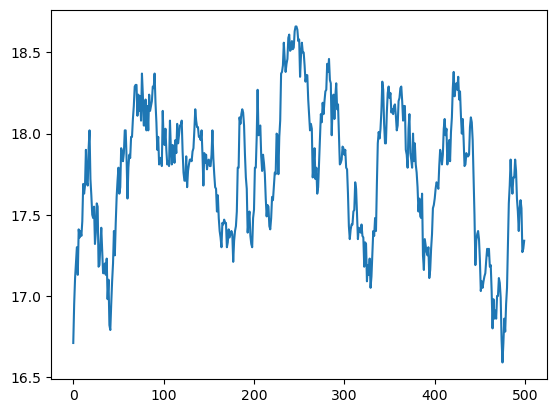

In [56]:
plt.plot(df['stock_29'] - df['stock_30'])